## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

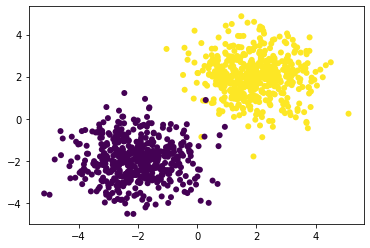

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()



# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [11]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

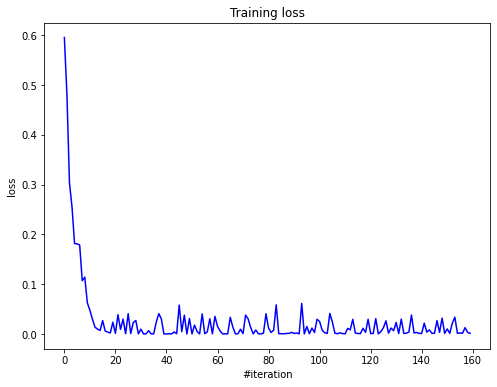

Current loss: 0.001467


In [12]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [29]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten= True)

One-hot encode the labels first.

In [30]:
# Your code goes here.Compare ################################################
def oneHotEncode(y):
  y_encode = np.zeros((y.shape[0], y.max()+1), dtype=np.float32) 
  y_encode[np.arange(y.shape[0]), y] = 1   
  return y_encode 

y_train = oneHotEncode(y_train)
y_val = oneHotEncode(y_val)
y_test = oneHotEncode(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [15]:
#Compute accuracy
def accuracy(y1, y2):
  return np.mean( np.argmax(y1, axis = 1) == np.argmax(y2, axis = 1) )

def one_epoch(net,X,Y, batch_size, critetion, optimizer, optimizer_cofig,optimizer_state):
  for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        # Forward
        predictions = net.forward(x_batch)    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      

#Make two figures for loss and accuracy
def make_plots(losses, accuracy_s,name):
  #losses -  dict consict of the net's name as the key and the array of it's loss in each epoch  
  #accuracy_s - the same as the losses
  #name - title of figures
  plt.figure(figsize=(8, 6))
  for item in losses.items():
    plt.title(name + " loss ") 
    plt.xlabel("num epochs")
    plt.ylabel("loss")
    label = item[0] + ' with loss ' + str(item[1][-1])
    plt.plot(item[1], label = label)
  
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure(figsize=(8, 6))
  for item in accuracy_s.items():
    plt.title(name + " accuracy" )
    plt.xlabel("num epochs")
    plt.ylabel("accuracy")
    label = item[0] + ' with accuracy ' + str(item[1][-1])
    plt.plot(item[1], label = label)
  
  plt.legend()
  plt.grid()
  plt.show()


In [16]:
def train_all_nets(num_epochs, batch_size,activations,X_train,y_train,X_test,y_test, criterion, optimizer, optimizer_config,optimizer_state, batch_norm = False):
  #batch_norm  - if true net include BatchNormalisation and ChannelwiseScaling layers after  each Linear layer
  nets = {}
  train_losses = {}
  train_accuracy_s = {}
  test_losses = {}
  test_accuracy_s = {}
  times = {}
  for func in activations :
    #initilaze the net for given activacion function
    print("Starting train: " + str(func))
    print()
    net = Sequential()
    net.add(Linear(784, 200))
    if batch_norm:
      net.add(BatchNormalization(alpha = 0.1))
      net.add(ChannelwiseScaling(200))
    net.add(func)
    net.add(Linear(200, 100))
    if batch_norm:
      net.add(BatchNormalization(alpha = 0.1))
      net.add(ChannelwiseScaling(100))
    net.add(func)
    net.add(Linear(100, 10))
    net.add(LogSoftMax())
    net_train_loss = []
    net_train_accuracy = []
    net_test_loss = []
    net_test_accuracy = []
    cur_time = 0
    #train the net
    for i in tqdm(range(num_epochs)):
      net.train()
      time1 = time()
      one_epoch(net,X_train,y_train,batch_size,criterion, optimizer, optimizer_config, optimizer_state)
      time2 = time()
      cur_time += time2-time1
      predictions = net.forward(X_train)
      net_train_loss.append(criterion.forward(predictions, y_train))
      net_train_accuracy.append(accuracy(predictions, y_train))
      net.evaluate()
      predictions = net.forward(X_test)
      net_test_loss.append(criterion.forward(predictions, y_test))
      net_test_accuracy.append(accuracy(predictions, y_test))
    times.update({str(func) : cur_time})
    nets.update({str(func) : net})
    train_losses.update({str(func) : net_train_loss})
    train_accuracy_s.update({str(func) : net_train_accuracy})
    test_losses.update({str(func) : net_test_loss})
    test_accuracy_s.update({str(func) : net_test_accuracy})
  return nets, train_losses, train_accuracy_s, test_losses, test_accuracy_s, times 

### Compare ReLU, ELU, LeakyReLU, SoftPlus activation functions


In [ ]:
num_epochs = 10
batch_size = 128
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 10e-6}
optimizer_state = {}
activations = [ReLU(), ELU(), LeakyReLU(), SoftPlus()]
criterion = ClassNLLCriterion()
optimizer = sgd_momentum
nets , train_loss, train_acc,test_loss, test_acc, times = train_all_nets(num_epochs, batch_size,activations,X_train,y_train,X_test,y_test, 
                                           criterion, optimizer, optimizer_config,optimizer_state)


  0%|          | 0/10 [00:00<?, ?it/s]

Starting train: ReLU




100%|██████████| 10/10 [00:50<00:00,  5.06s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Starting train: ELU




100%|██████████| 10/10 [01:06<00:00,  6.68s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Starting train: LeakyReLU




100%|██████████| 10/10 [00:51<00:00,  5.16s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

Starting train: SoftPlus




100%|██████████| 10/10 [01:17<00:00,  7.75s/it]


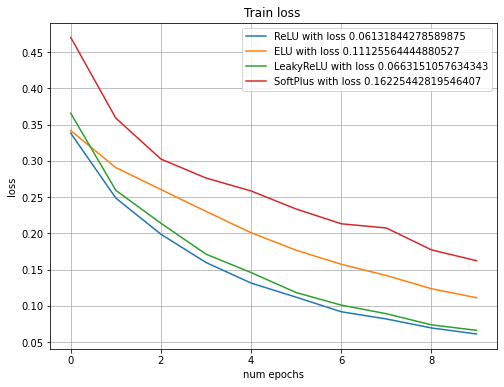

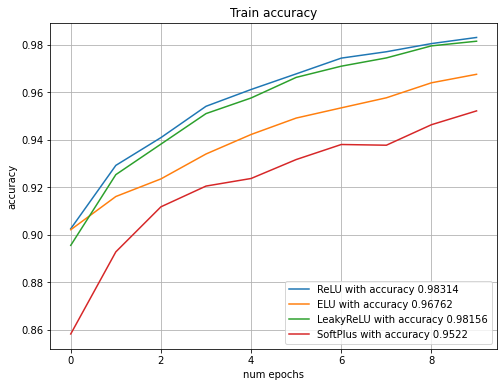

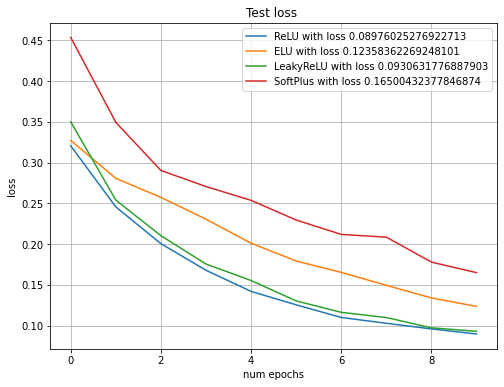

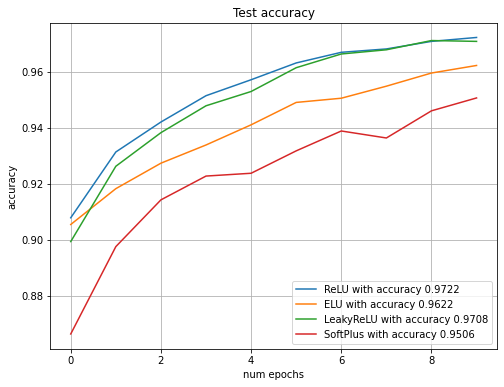

In [ ]:
make_plots(train_loss, train_acc,'Train')
make_plots(test_loss, test_acc,'Test')

In [ ]:
times

{'ELU': 51.822999000549316,
 'LeakyReLU': 40.78936290740967,
 'ReLU': 40.05254650115967,
 'SoftPlus': 58.277217388153076}

$\textbf{Conclusion:}$  As shown at figures  the best activasion function is ReLU because it has the best test accuracy and the best speed. Perhaps, the reason of the best accuracy is that ReLU suffers less from the vanishing gradient problem.

### Try inserting BatchNormalization

In [ ]:
num_epochs = 10
batch_size = 128
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 10e-6}
optimizer_state = {}
activations = [ReLU()]
criterion = ClassNLLCriterion()
optimizer = sgd_momentum
nets_relu , relu_train_loss, relu_train_acc,relu_test_loss, relu_test_acc,times_relu  = train_all_nets(num_epochs, batch_size,activations,X_train,y_train,X_test,y_test, 
                                           criterion, optimizer, optimizer_config,optimizer_state)


  0%|          | 0/10 [00:00<?, ?it/s]

Starting train: ReLU




100%|██████████| 10/10 [00:52<00:00,  5.27s/it]


In [ ]:
num_epochs = 10
batch_size = 128
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 10e-6}
optimizer_state = {}
activations = [ReLU()]
criterion = ClassNLLCriterion()
optimizer = sgd_momentum
nets_norm_relu , norm_relu_train_loss, norm_relu_train_acc,norm_relu_test_loss, norm_relu_test_acc, times_norm_relu = train_all_nets(num_epochs, batch_size,activations,X_train,y_train,X_test,y_test, 
                                           criterion, optimizer, optimizer_config,optimizer_state, batch_norm = True)



  0%|          | 0/10 [00:00<?, ?it/s]

Starting train: ReLU




100%|██████████| 10/10 [01:01<00:00,  6.15s/it]


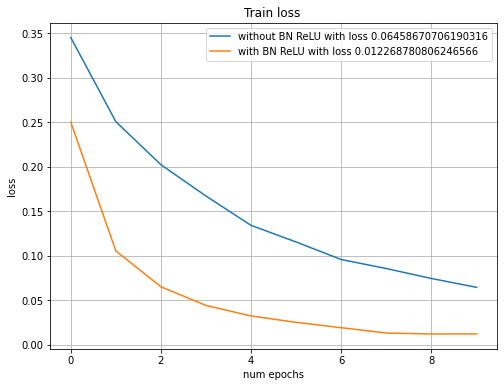

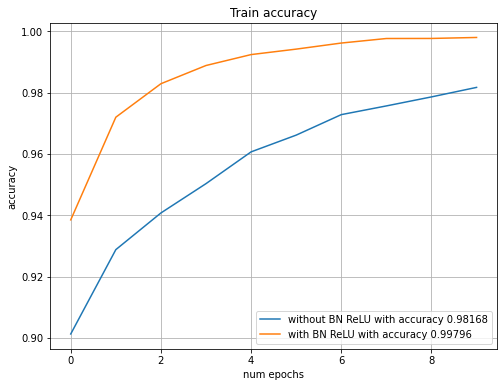

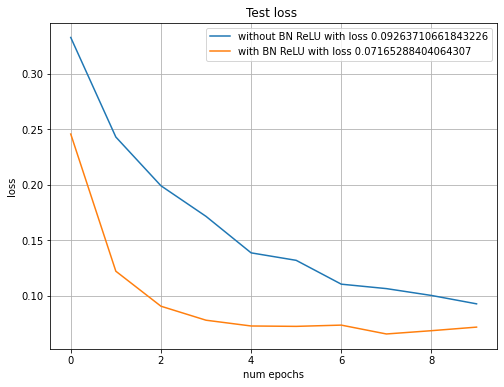

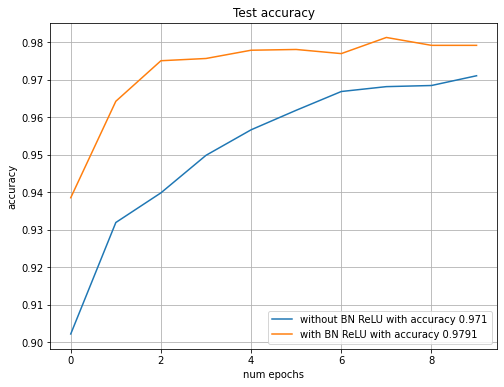

In [ ]:
new_train_loss = {}
new_train_acc = {}
new_test_loss = {}
new_test_acc = {}

for item in relu_train_loss.items():
  name ="without BN " +  item[0]
  new_train_loss.update({name : item[1]}) 
for item in relu_train_acc.items():
  name ="without BN " +  item[0]
  new_train_acc.update({name : item[1]}) 
for item in norm_relu_train_loss.items():
  name ="with BN " +  item[0]
  new_train_loss.update({name : item[1]}) 
for item in norm_relu_train_acc.items():
  name ="with BN " +  item[0]
  new_train_acc.update({name : item[1]})

for item in relu_test_loss.items():
  name ="without BN " +  item[0]
  new_test_loss.update({name : item[1]}) 
for item in relu_test_acc.items():
  name ="without BN " +  item[0]
  new_test_acc.update({name : item[1]}) 
for item in norm_relu_test_loss.items():
  name ="with BN " +  item[0]
  new_test_loss.update({name : item[1]}) 
for item in norm_relu_test_acc.items():
  name ="with BN " +  item[0]
  new_test_acc.update({name : item[1]}) 

make_plots(new_train_loss, new_train_acc,'Train')
make_plots(new_test_loss, new_test_acc,'Test')


In [ ]:
print("Without BN " , times_relu)
print("With BN", times_norm_relu)

Without BN  {'ReLU': 41.96685719490051}
With BN {'ReLU': 48.25151038169861}


$\textbf{Conclusion:}$  As shown at figures  net with BatchNormalizatoin gives better results. It converges faster and has better accuracy.

### Plot the losses for two networks

In [ ]:
num_epochs = 10
batch_size = 128
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9, 'beta1': 0.9, 'beta2': 0.99, 'epsilon': 10e-6}
optimizer_state = {}
activations = [ReLU()]
criterion = ClassNLLCriterion()
optimizer = sgd_momentum
nets_sgd , sgd_train_loss, sgd_train_acc,sgd_test_loss, sgd_test_acc, times_sgd = train_all_nets(num_epochs, batch_size,activations,X_train,y_train,X_test,y_test, 
                                           criterion, optimizer, optimizer_config,optimizer_state, batch_norm = True)


  0%|          | 0/10 [00:00<?, ?it/s]

Starting train: ReLU




100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


In [ ]:
num_epochs = 10
batch_size = 128
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9, 'beta1': 0.9, 'beta2': 0.99, 'epsilon': 10e-6}
optimizer_state = {}
activations = [ReLU()]
criterion = ClassNLLCriterion()
optimizer = adam_optimizer
nets_adam , adam_train_loss, adam_train_acc,adam_test_loss, adam_test_acc, times_adam = train_all_nets(num_epochs, batch_size,activations,X_train,y_train,X_test,y_test, 
                                           criterion, optimizer, optimizer_config,optimizer_state, batch_norm = True)


  0%|          | 0/10 [00:00<?, ?it/s]

Starting train: ReLU




100%|██████████| 10/10 [01:13<00:00,  7.34s/it]


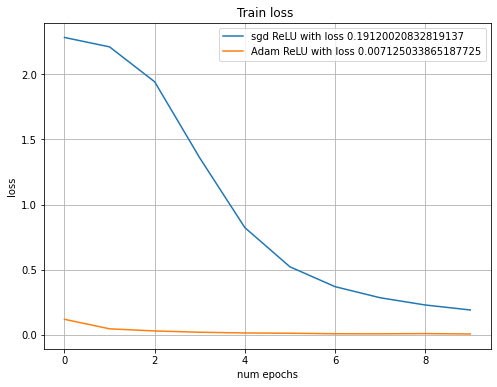

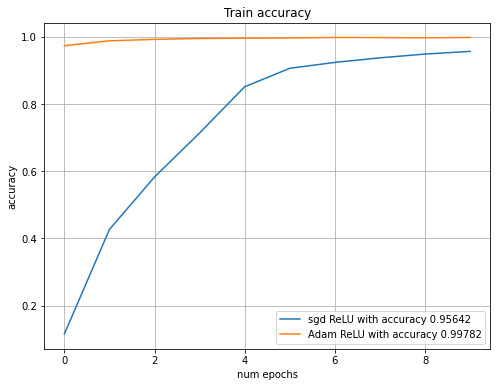

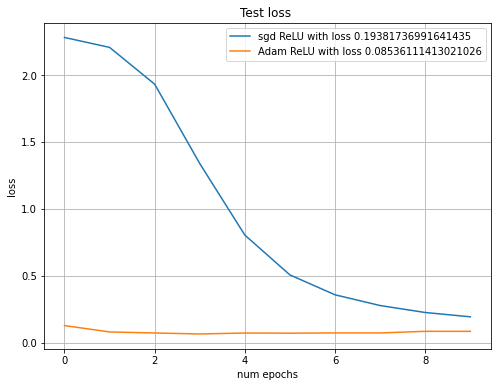

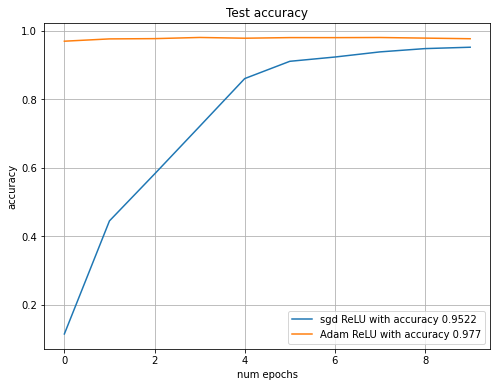

In [ ]:
new_train_loss = {}
new_train_acc = {}
new_test_loss = {}
new_test_acc = {}

for item in sgd_train_loss.items():
  name ="sgd " +  item[0]
  new_train_loss.update({name : item[1]}) 
for item in sgd_train_acc.items():
  name ="sgd " +  item[0]
  new_train_acc.update({name : item[1]}) 
for item in adam_train_loss.items():
  name ="Adam " +  item[0]
  new_train_loss.update({name : item[1]}) 
for item in adam_train_acc.items():
  name ="Adam " +  item[0]
  new_train_acc.update({name : item[1]})

for item in sgd_test_loss.items():
  name ="sgd " +  item[0]
  new_test_loss.update({name : item[1]}) 
for item in sgd_test_acc.items():
  name ="sgd " +  item[0]
  new_test_acc.update({name : item[1]}) 
for item in adam_test_loss.items():
  name ="Adam " +  item[0]
  new_test_loss.update({name : item[1]}) 
for item in adam_test_acc.items():
  name ="Adam " +  item[0]
  new_test_acc.update({name : item[1]}) 

make_plots(new_train_loss, new_train_acc,'Train')
make_plots(new_test_loss, new_test_acc,'Test')


In [ ]:
print("sgd ", times_sgd)
print('Adam ', times_adam)

sgd  {'ReLU': 49.972980976104736}
Adam  {'ReLU': 60.14649844169617}


$\textbf{Conclusion:}$ As shown at figures adam optimizer has better convergence (about 2 epochs) and has better accuracy. 

### Super cool model

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [31]:
# Your code goes here. ################################################
num_epochs = 10
batch_size = 128
optimizer = adam_optimizer
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9, 'beta1': 0.9, 'beta2': 0.99, 'epsilon': 10e-6}
optimizer_state = {}
net = Sequential()
net.add(Linear(784, 200))
net.add(BatchNormalization(alpha = 0.1))
net.add(ChannelwiseScaling(200))
net.add(Dropout(0.5))
net.add(ReLU())
net.add(Linear(200, 100))
net.add(BatchNormalization(alpha = 0.1))
net.add(ChannelwiseScaling(100))
net.add(ReLU())
net.add(Linear(100, 10))
net.add(LogSoftMax())

net_train_loss = []
net_train_accuracy = []
net_test_loss = []
net_test_accuracy = []
cur_time = 0
for i in tqdm(range(num_epochs)):
  net.train()
  time1 = time()
  one_epoch(net,X_train,y_train,batch_size,criterion, optimizer, optimizer_config, optimizer_state)
  time2 = time()
  cur_time += time2-time1
  predictions = net.forward(X_train)
  net_train_loss.append(criterion.forward(predictions, y_train))
  net_train_accuracy.append(accuracy(predictions, y_train))
  net.evaluate()
  predictions = net.forward(X_test)
  net_test_loss.append(criterion.forward(predictions, y_test))
  net_test_accuracy.append(accuracy(predictions, y_test))

100%|██████████| 10/10 [00:55<00:00,  5.52s/it]


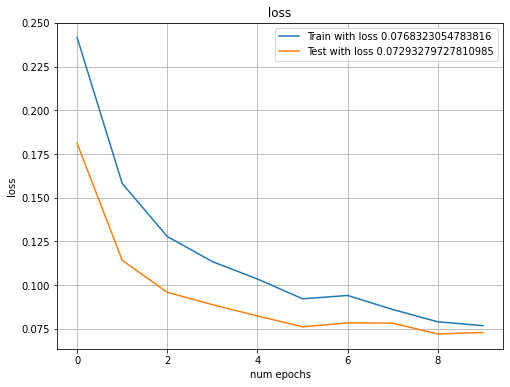

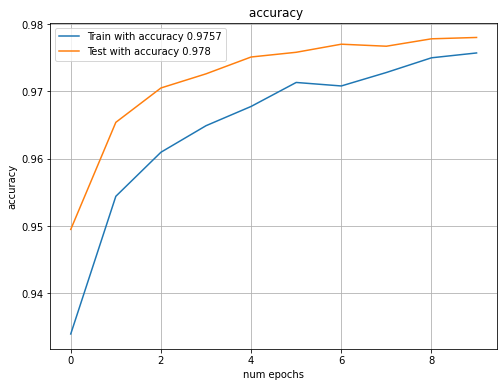

Time is  43.28628945350647


In [32]:
make_plots({'Train' : net_train_loss, 'Test' : net_test_loss} , {"Train" : net_train_accuracy, 'Test' : net_test_accuracy}, '')
print('Time is ', cur_time)

Print here your accuracy on test set. It should be around 90%.

$\textbf{Conclusion:}$ Using the ReLU activatoin function after Linear layers, BatchNormalization layers, Adam optimizer  and the Dropout layer, i get 0.98 test accuracy. Because of the Dropout layer train accuracy is worse than test, but this shows that my net isn't overfitted (also it is indicated by the distance between train and test accuracy).

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [67]:
# Your beautiful code here.
import torch
from torch import nn


X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten= True)
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)
X_test = torch.Tensor(X_test)

y_train = oneHotEncode(y_train)
y_val = oneHotEncode(y_val)
y_test = oneHotEncode(y_test)

y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)
y_test = torch.Tensor(y_test)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

loss_func = nn.NLLLoss()

num_epochs = 9
batch_size = 128
model = nn.Sequential(
  nn.Linear(784, 200), 
  nn.BatchNorm1d(200),
  nn.Dropout(0.5),
  nn.ReLU(),
  nn.Linear(200, 100),
  nn.BatchNorm1d(100),
  nn.ReLU(),
  nn.Linear(100, 10),
  nn.LogSoftmax(dim = 1 )
)

model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), betas = (0.9, 0.99),  eps =  10e-6)



In [68]:
def train_model(model, X_train, y_train, X_test, y_test,batch_size, loss_fn, opt, n_epochs: int, device=device):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in get_batches((X_train,y_train), batch_size):
            opt.zero_grad()
            # move data to target device
          
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            out = model(X_batch)
            target = torch.argmax(y_batch, dim=1)
            loss = loss_fn(out, target)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in get_batches((X_test,y_test), batch_size):
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
                out = model(X_batch)
                target = torch.argmax(y_batch, dim=1)
                loss = loss_fn(out, target)


                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]### YOUR CODE HERE
                y_batch = y_batch.max(dim = 1 )[1]         
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [69]:
train_loss, test_loss , test_accuracy = train_model(model, X_train, y_train, X_test,y_test, batch_size, loss_func, opt, num_epochs )

Epoch 1 of 9 took 4.168s
	  training loss: 0.423568
	validation loss: 0.150327
	validation accuracy: 0.954
Epoch 2 of 9 took 4.119s
	  training loss: 0.198207
	validation loss: 0.112033
	validation accuracy: 0.966
Epoch 3 of 9 took 4.115s
	  training loss: 0.161733
	validation loss: 0.097588
	validation accuracy: 0.969
Epoch 4 of 9 took 4.167s
	  training loss: 0.142577
	validation loss: 0.084491
	validation accuracy: 0.975
Epoch 5 of 9 took 4.120s
	  training loss: 0.127892
	validation loss: 0.078956
	validation accuracy: 0.975
Epoch 6 of 9 took 4.129s
	  training loss: 0.118375
	validation loss: 0.074240
	validation accuracy: 0.977
Epoch 7 of 9 took 4.114s
	  training loss: 0.105583
	validation loss: 0.069773
	validation accuracy: 0.978
Epoch 8 of 9 took 4.127s
	  training loss: 0.098105
	validation loss: 0.064449
	validation accuracy: 0.980
Epoch 9 of 9 took 4.080s
	  training loss: 0.092153
	validation loss: 0.067017
	validation accuracy: 0.979


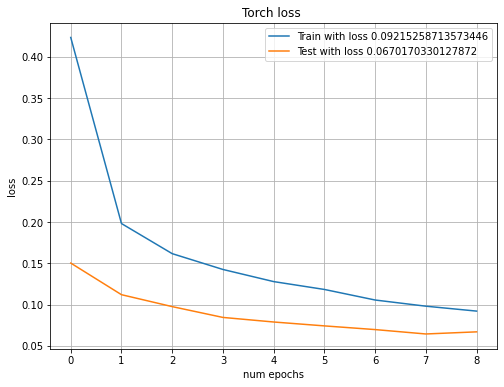

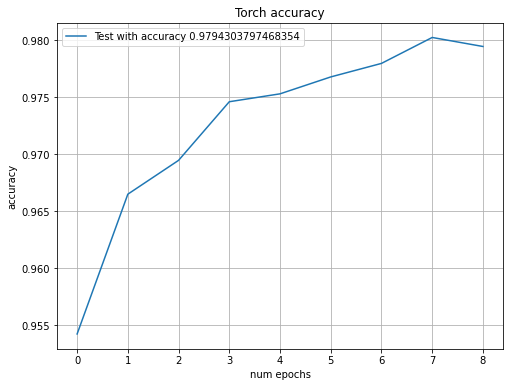

In [70]:
make_plots({"Train" : train_loss, 'Test' : test_loss}, {'Test' : test_accuracy}, "Torch")